In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, scale
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score


%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')

In [3]:
def preprocessing_data(data, unique_home_ownership=None, unique_verification=None, dict_grade=None,dict_sub_grade=None, dict_emp_title=None, dict_pymnt_plan=None, dict_purpose=None):
    numeric_data = data.drop(['record_id', 'earliest_cr_line', 'issue_d', 'addr_state', 'zip_code'], axis=1)
    
    numeric_data['term'] = numeric_data['term'].map({' 36 months': 0, ' 60 months': 1})
    numeric_data['application_type'] = numeric_data['application_type'].map({'INDIVIDUAL': 0, 'JOINT': 1})
    numeric_data['initial_list_status'] = numeric_data['initial_list_status'].map({'f': 0, 'w': 1})
    numeric_data['emp_length'] = numeric_data['emp_length'].map({'< 1 year': 1, '1 year': 2, '2 years': 3,  '3 years': 4,  '4 years': 5,  '5 years': 6,  '6 years': 7,  '7 years': 8,  '8 years': 9,  '9 years': 10,  '10+ years': 11})

    numeric_data['emp_length'].fillna(0, inplace=True)
    numeric_data['emp_title'].fillna('0', inplace=True)
    numeric_data['mths_since_last_delinq'].fillna(numeric_data['mths_since_last_delinq'].notnull().min(), inplace=True)
    numeric_data['collections_12_mths_ex_med'].fillna(numeric_data['collections_12_mths_ex_med'].notnull().max(), inplace=True)
    numeric_data['revol_util'].fillna(numeric_data['revol_util'].notnull().mean(), inplace=True)
    numeric_data['tot_coll_amt'].fillna(numeric_data['tot_coll_amt'].notnull().min(), inplace=True)
    numeric_data['tot_cur_bal'].fillna(numeric_data['tot_cur_bal'].notnull().min(), inplace=True)
    numeric_data['total_rev_hi_lim'].fillna(numeric_data['total_rev_hi_lim'].notnull().min(), inplace=True)
  
    home_ownership_list = numeric_data.home_ownership.values.reshape(-1, 1)

    numeric_data = pd.concat((numeric_data,pd.get_dummies(numeric_data.home_ownership)),1)
    
    if unique_home_ownership is None:
        unique_home_ownership = numeric_data['home_ownership'].unique()
        
    for i in unique_home_ownership:
        try:
            numeric_data[i]
        except KeyError:
            numeric_data[i] = 0
    
#     print(pd.get_dummies(numeric_data.home_ownership))
#     for i in array_home:
#         print(i)
#     numeric_data['home_ownership_ohe'] = array_home
#     print(ohe.get_feature_names())
#     print(array_home[25])
#         step = len(array_home[0])
#         array_home = array_home.reshape(len(array_home)*len(array_home[0]), 1)
#         for i in range(step):        
#             length = array_home[i::step]
#     #         print(len(length))
#             numeric_data['home_ownership_ohe'+str(i)] = array_home[i::step]

    verification_list = numeric_data.verification_status.values.reshape(-1, 1)

    numeric_data = pd.concat((numeric_data,pd.get_dummies(numeric_data.verification_status)),1)
    
    if unique_verification is None:
        unique_verification = numeric_data['verification_status'].unique()
#     else:
#         new_unique_home_ownership = numeric_data['home_ownership'].unique()
#         for i in list(set(unique_home_ownership)^set(new_unique_home_ownership)):
#             print(i)
#             numeric_data = numeric_data.drop([i], axis=1)
        
    for i in unique_verification:
        try:
            numeric_data[i]
        except KeyError:
            numeric_data[i] = 0
    
    le = LabelEncoder()

    if dict_grade is None:
        le.fit(numeric_data.grade.astype(str))
        numeric_data['grade_le'] = le.transform((numeric_data['grade'].values))
        dict_grade = dict(zip(le.classes_, le.transform(le.classes_)))
    else:
        numeric_data['grade_le'] = numeric_data['grade'].map(dict_grade).fillna(-1)  

    if dict_sub_grade is None:
        le.fit(numeric_data.sub_grade.astype(str))
        numeric_data['sub_grade_le'] = le.transform(numeric_data['sub_grade'].values)
        dict_sub_grade = dict(zip(le.classes_, le.transform(le.classes_)))
    else:
        numeric_data['sub_grade_le'] = numeric_data['sub_grade'].map(dict_sub_grade).fillna(-1)  
    
    if dict_emp_title is None:
        le.fit(numeric_data.emp_title.astype(str))
        numeric_data['emp_title_le'] = le.transform(numeric_data['emp_title'].values)
        dict_emp_title = dict(zip(le.classes_, le.transform(le.classes_)))
    else:
        numeric_data['emp_title_le'] = numeric_data['emp_title'].map(dict_emp_title).fillna(-1)        

    if dict_pymnt_plan is None:
        le.fit(numeric_data.pymnt_plan.astype(str))
        numeric_data['pymnt_plan_le'] = le.transform(numeric_data['pymnt_plan'].values)
        dict_pymnt_plan = dict(zip(le.classes_, le.transform(le.classes_)))
    else:
        numeric_data['pymnt_plan_le'] = numeric_data['pymnt_plan'].map(dict_pymnt_plan).fillna(0)  
    
    if dict_purpose is None:
        le.fit(numeric_data.purpose.astype(str))
        numeric_data['purpose_le'] = le.transform(numeric_data['purpose'].values)
        dict_purpose = dict(zip(le.classes_, le.transform(le.classes_)))
#         dict_purpose[None] = 5
    else:
        numeric_data['purpose_le'] = numeric_data['purpose'].map(dict_purpose).fillna(-1) 
#     print(dict_grade)

    numeric_data = numeric_data.drop(['grade', 'sub_grade', 'purpose', 'home_ownership','emp_title', 'pymnt_plan',  'verification_status'], axis=1)
    
    return numeric_data, unique_home_ownership, unique_verification, dict_grade, dict_sub_grade, dict_emp_title, dict_pymnt_plan, dict_purpose

In [4]:
train, test = train_test_split(data, test_size=0.3, random_state=42)

In [5]:
train, unique_home_ownership, unique_verification, dict_grade, dict_sub_grade, dict_emp_title, dict_pymnt_plan, dict_purpose = preprocessing_data(train)
test = preprocessing_data(test,unique_home_ownership, unique_verification, dict_grade, dict_sub_grade, dict_emp_title, dict_pymnt_plan, dict_purpose)[0]

In [6]:
X_train = train.drop(['loan_status'], axis=1)
y_train = train['loan_status']

X_test = test.drop(['loan_status'], axis=1)
y_test = test['loan_status']

X_train = scale(X_train)
X_test = scale(X_test)

ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)
# print(len(y_train))

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int32, int64, float64, object were all converted to float64 by the scale function.
  import sys
C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64, object were all converted to float64 by the scale function.
  


In [8]:
model_l1 = LogisticRegression(penalty='l1', random_state=42)
model_l1.fit(X_train, y_train)
preds = model_l1.predict(X_test)

print('l1: ')
print('Accuracy score: ' + str(metrics.accuracy_score(y_test, preds)))

print('Recall score: ' + str(metrics.recall_score(y_test, preds)))

print('Precision score: ' + str(metrics.precision_score(y_test, preds)))

print('Auc score: ' + str(metrics.roc_auc_score(y_test, preds)))

/home/anna/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


l1: 
Accuracy score: 0.6546447541502239
Recall score: 0.660304364553499
Precision score: 0.8643574606194566
Auc score: 0.6474982752614531


In [8]:
model_l2 = LogisticRegression(penalty='l2', random_state=42)
model_l2.fit(X_train, y_train)
preds = model_l2.predict(X_test)

print('l2: ')
print('Accuracy score: ' + str(metrics.accuracy_score(y_test, preds)))

print('Recall score: ' + str(metrics.recall_score(y_test, preds)))

print('Precision score: ' + str(metrics.precision_score(y_test, preds)))

print('Auc score: ' + str(metrics.roc_auc_score(y_test, preds)))

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


l2: 
Accuracy score: 0.654394991424813
Recall score: 0.6587440687385115
Precision score: 0.8654872226902556
Auc score: 0.6489033432382182


In [128]:
def acc_model(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

param_space = {
    'max_depth': hp.choice('max_depth', [3, 5, 7, 9]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [3, 5]),
    'n_estimators': hp.choice('n_estimators', [100, 200, 500]),
#     'criterion': hp.choice('criterion', ["entropy","gini"])
}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=10, trials=trials)
print ('best:')
print (best)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                           
0.6554213702291357                                  
{'max_depth': 7, 'min_samples_leaf': 5, 'n_estimators': 200}
 10%|█         | 1/10 [02:15<20:17, 135.23s/it, best loss: -0.6554213702291357]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6554213702291357                                                             
{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 100}                   
 20%|██        | 2/10 [02:52<14:05, 105.71s/it, best loss: -0.6554213702291357]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6556785492216448                                                             
{'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 500}                   
 30%|███       | 3/10 [08:21<20:09, 172.83s/it, best loss: -0.6556785492216448]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6696808438745588                                                             
{'max_depth': 9, 'min_samples_leaf': 5, 'n_estimators': 500}                   
 40%|████      | 4/10 [15:08<24:19, 243.20s/it, best loss: -0.6696808438745588]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6696808438745588                                                             
{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 200}                   
 50%|█████     | 5/10 [16:50<16:44, 200.84s/it, best loss: -0.6696808438745588]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6696808438745588                                                             
{'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 100}                   
 60%|██████    | 6/10 [18:12<11:00, 165.19s/it, best loss: -0.6696808438745588]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6696808438745588                                                             
{'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 200}                   
 70%|███████   | 7/10 [20:54<08:12, 164.14s/it, best loss: -0.6696808438745588]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6696808438745588                                                             
{'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100}                   
 80%|████████  | 8/10 [21:30<04:11, 125.81s/it, best loss: -0.6696808438745588]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6696808438745588                                                             
{'max_depth': 7, 'min_samples_leaf': 5, 'n_estimators': 500}                   
 90%|█████████ | 9/10 [26:58<03:06, 186.22s/it, best loss: -0.6696808438745588]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6696808438745588                                                             
{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 200}                   
100%|██████████| 10/10 [28:41<00:00, 161.26s/it, best loss: -0.6696808438745588]
best:
{'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 2}


In [9]:
forest_tree = RandomForestClassifier(n_estimators=500, min_samples_leaf=5, max_depth=9, n_jobs=-1, random_state=42)

forest_tree.fit(X_train, y_train)
preds = forest_tree.predict(X_test)

print('Forest: ')
print('Accuracy score: ' + str(metrics.accuracy_score(y_test, preds)))

print('Recall score: ' + str(metrics.recall_score(y_test, preds)))

print('Precision score: ' + str(metrics.precision_score(y_test, preds)))

print('Auc score: ' + str(metrics.roc_auc_score(y_test, preds)))

Forest: 
Accuracy score: 0.6430058111460779
Recall score: 0.6383747274825803
Precision score: 0.8685297196696522
Auc score: 0.6488535531769016


In [16]:
def acc_model(params):
    clf = DecisionTreeClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

param_space = {
    'max_depth': hp.choice('max_depth', [3, 5, 7, 9]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [3, 5])
}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=10, trials=trials)
print ('best:')
print (best)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                           
0.6388059630862529                                  
{'max_depth': 5, 'min_samples_leaf': 5}             
 10%|█         | 1/10 [00:03<00:30,  3.39s/it, best loss: -0.6388059630862529]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                     
0.6388059630862529                                                            
{'max_depth': 5, 'min_samples_leaf': 3}                                       
 20%|██        | 2/10 [00:06<00:27,  3.39s/it, best loss: -0.6388059630862529]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                     
0.648468426571989                                                             
{'max_depth': 7, 'min_samples_leaf': 3}                                       
 30%|███       | 3/10 [00:11<00:26,  3.75s/it, best loss: -0.648468426571989] 

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                    
0.648468426571989                                                            
{'max_depth': 7, 'min_samples_leaf': 5}                                      
 40%|████      | 4/10 [00:15<00:23,  3.97s/it, best loss: -0.648468426571989]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                    
0.6562480117211505                                                           
{'max_depth': 9, 'min_samples_leaf': 5}                                      
 50%|█████     | 5/10 [00:21<00:22,  4.43s/it, best loss: -0.6562480117211505]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                     
0.6562480117211505                                                            
{'max_depth': 5, 'min_samples_leaf': 3}                                       
 60%|██████    | 6/10 [00:24<00:16,  4.11s/it, best loss: -0.6562480117211505]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                     
0.6562480117211505                                                            
{'max_depth': 5, 'min_samples_leaf': 3}                                       
 70%|███████   | 7/10 [00:28<00:11,  3.91s/it, best loss: -0.6562480117211505]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                     
0.6562480117211505                                                            
{'max_depth': 5, 'min_samples_leaf': 5}                                       
 80%|████████  | 8/10 [00:31<00:07,  3.75s/it, best loss: -0.6562480117211505]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                     
0.6562480117211505                                                            
{'max_depth': 3, 'min_samples_leaf': 3}                                       
 90%|█████████ | 9/10 [00:33<00:03,  3.33s/it, best loss: -0.6562480117211505]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                     
0.6562480117211505                                                            
{'max_depth': 3, 'min_samples_leaf': 3}                                       
100%|██████████| 10/10 [00:36<00:00,  3.01s/it, best loss: -0.6562480117211505]
best:
{'max_depth': 3, 'min_samples_leaf': 1}


In [10]:
reg_tree = DecisionTreeClassifier(max_depth=9, min_samples_leaf=5, random_state=42)

reg_tree.fit(X_train, y_train)
preds = reg_tree.predict(X_test)

print('Tree: ')
print('Accuracy score: ' + str(metrics.accuracy_score(y_test, preds)))

print('Recall score: ' + str(metrics.recall_score(y_test, preds)))

print('Precision score: ' + str(metrics.precision_score(y_test, preds)))

print('Auc score: ' + str(metrics.roc_auc_score(y_test, preds)))

Tree: 
Accuracy score: 0.6527299065887407
Recall score: 0.6678066088146026
Precision score: 0.8546419388369166
Auc score: 0.6336923180460625


In [ ]:
def acc_model(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

param_space = {
    'n_neighbors': hp.choice('n_neighbors', [3, 5, 7])
}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=3, trials=trials)
print ('best:')
print (best)

  0%|          | 0/3 [00:00<?, ?it/s, best loss: ?]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



In [13]:
from catboost import CatBoostClassifier


cat_reg = CatBoostClassifier()
cat_reg.fit(X_train, y_train)
preds = cat_reg.predict(X_test)

print('CatBoost: ')
print('Accuracy score: ' + str(metrics.accuracy_score(y_test, preds)))

print('Recall score: ' + str(metrics.recall_score(y_test, preds)))

print('Precision score: ' + str(metrics.precision_score(y_test, preds)))

print('Auc score: ' + str(metrics.roc_auc_score(y_test, preds)))

Learning rate set to 0.076872
0:	learn: 0.6844708	total: 106ms	remaining: 1m 46s
1:	learn: 0.6770576	total: 206ms	remaining: 1m 42s
2:	learn: 0.6706344	total: 333ms	remaining: 1m 50s
3:	learn: 0.6647387	total: 517ms	remaining: 2m 8s
4:	learn: 0.6602071	total: 656ms	remaining: 2m 10s
5:	learn: 0.6558869	total: 756ms	remaining: 2m 5s
6:	learn: 0.6520151	total: 876ms	remaining: 2m 4s
7:	learn: 0.6486525	total: 986ms	remaining: 2m 2s
8:	learn: 0.6459543	total: 1.09s	remaining: 1m 59s
9:	learn: 0.6434213	total: 1.2s	remaining: 1m 58s
10:	learn: 0.6412545	total: 1.28s	remaining: 1m 55s
11:	learn: 0.6393701	total: 1.4s	remaining: 1m 55s
12:	learn: 0.6376966	total: 1.49s	remaining: 1m 53s
13:	learn: 0.6362198	total: 1.59s	remaining: 1m 52s
14:	learn: 0.6348637	total: 1.7s	remaining: 1m 51s
15:	learn: 0.6336766	total: 1.79s	remaining: 1m 50s
16:	learn: 0.6324952	total: 1.9s	remaining: 1m 50s
17:	learn: 0.6314856	total: 2.01s	remaining: 1m 49s
18:	learn: 0.6305153	total: 2.11s	remaining: 1m 48s


157:	learn: 0.6045628	total: 17.2s	remaining: 1m 31s
158:	learn: 0.6045007	total: 17.3s	remaining: 1m 31s
159:	learn: 0.6044179	total: 17.4s	remaining: 1m 31s
160:	learn: 0.6042981	total: 17.5s	remaining: 1m 30s
161:	learn: 0.6042353	total: 17.5s	remaining: 1m 30s
162:	learn: 0.6041708	total: 17.7s	remaining: 1m 30s
163:	learn: 0.6041011	total: 17.8s	remaining: 1m 30s
164:	learn: 0.6040008	total: 18s	remaining: 1m 31s
165:	learn: 0.6039054	total: 18.2s	remaining: 1m 31s
166:	learn: 0.6038030	total: 18.2s	remaining: 1m 31s
167:	learn: 0.6037111	total: 18.3s	remaining: 1m 30s
168:	learn: 0.6035988	total: 18.4s	remaining: 1m 30s
169:	learn: 0.6035388	total: 18.5s	remaining: 1m 30s
170:	learn: 0.6034365	total: 18.6s	remaining: 1m 30s
171:	learn: 0.6033373	total: 18.8s	remaining: 1m 30s
172:	learn: 0.6032271	total: 19s	remaining: 1m 30s
173:	learn: 0.6031165	total: 19.1s	remaining: 1m 30s
174:	learn: 0.6029967	total: 19.3s	remaining: 1m 31s
175:	learn: 0.6029019	total: 19.4s	remaining: 1m 3

314:	learn: 0.5909958	total: 33.8s	remaining: 1m 13s
315:	learn: 0.5909134	total: 34s	remaining: 1m 13s
316:	learn: 0.5908455	total: 34.1s	remaining: 1m 13s
317:	learn: 0.5907715	total: 34.2s	remaining: 1m 13s
318:	learn: 0.5907089	total: 34.3s	remaining: 1m 13s
319:	learn: 0.5906239	total: 34.4s	remaining: 1m 13s
320:	learn: 0.5905545	total: 34.5s	remaining: 1m 12s
321:	learn: 0.5904615	total: 34.6s	remaining: 1m 12s
322:	learn: 0.5904053	total: 34.7s	remaining: 1m 12s
323:	learn: 0.5903009	total: 34.7s	remaining: 1m 12s
324:	learn: 0.5902269	total: 34.8s	remaining: 1m 12s
325:	learn: 0.5901776	total: 34.9s	remaining: 1m 12s
326:	learn: 0.5901416	total: 35s	remaining: 1m 12s
327:	learn: 0.5900883	total: 35.1s	remaining: 1m 11s
328:	learn: 0.5900033	total: 35.2s	remaining: 1m 11s
329:	learn: 0.5899050	total: 35.3s	remaining: 1m 11s
330:	learn: 0.5898487	total: 35.4s	remaining: 1m 11s
331:	learn: 0.5897838	total: 35.5s	remaining: 1m 11s
332:	learn: 0.5897001	total: 35.6s	remaining: 1m 1

474:	learn: 0.5798003	total: 49.5s	remaining: 54.8s
475:	learn: 0.5797435	total: 49.6s	remaining: 54.6s
476:	learn: 0.5796840	total: 49.7s	remaining: 54.5s
477:	learn: 0.5796066	total: 49.8s	remaining: 54.4s
478:	learn: 0.5795328	total: 49.9s	remaining: 54.3s
479:	learn: 0.5794670	total: 50s	remaining: 54.2s
480:	learn: 0.5794200	total: 50.1s	remaining: 54.1s
481:	learn: 0.5793485	total: 50.3s	remaining: 54.1s
482:	learn: 0.5792626	total: 50.4s	remaining: 54s
483:	learn: 0.5792169	total: 50.5s	remaining: 53.9s
484:	learn: 0.5791549	total: 50.6s	remaining: 53.8s
485:	learn: 0.5790686	total: 50.8s	remaining: 53.7s
486:	learn: 0.5790078	total: 51s	remaining: 53.7s
487:	learn: 0.5789450	total: 51.2s	remaining: 53.7s
488:	learn: 0.5788877	total: 51.4s	remaining: 53.7s
489:	learn: 0.5788316	total: 51.5s	remaining: 53.6s
490:	learn: 0.5787837	total: 51.7s	remaining: 53.6s
491:	learn: 0.5787101	total: 51.8s	remaining: 53.5s
492:	learn: 0.5786514	total: 51.9s	remaining: 53.4s
493:	learn: 0.5785

635:	learn: 0.5698581	total: 1m 7s	remaining: 38.6s
636:	learn: 0.5697959	total: 1m 7s	remaining: 38.4s
637:	learn: 0.5697371	total: 1m 7s	remaining: 38.3s
638:	learn: 0.5696765	total: 1m 7s	remaining: 38.2s
639:	learn: 0.5696143	total: 1m 7s	remaining: 38.1s
640:	learn: 0.5695658	total: 1m 7s	remaining: 38s
641:	learn: 0.5694911	total: 1m 7s	remaining: 37.9s
642:	learn: 0.5694297	total: 1m 8s	remaining: 37.8s
643:	learn: 0.5693470	total: 1m 8s	remaining: 37.7s
644:	learn: 0.5692796	total: 1m 8s	remaining: 37.5s
645:	learn: 0.5692177	total: 1m 8s	remaining: 37.4s
646:	learn: 0.5691509	total: 1m 8s	remaining: 37.3s
647:	learn: 0.5691223	total: 1m 8s	remaining: 37.2s
648:	learn: 0.5690617	total: 1m 8s	remaining: 37.1s
649:	learn: 0.5690021	total: 1m 8s	remaining: 37s
650:	learn: 0.5689513	total: 1m 8s	remaining: 36.9s
651:	learn: 0.5689022	total: 1m 8s	remaining: 36.7s
652:	learn: 0.5688134	total: 1m 8s	remaining: 36.6s
653:	learn: 0.5687600	total: 1m 9s	remaining: 36.5s
654:	learn: 0.56

792:	learn: 0.5610425	total: 1m 22s	remaining: 21.5s
793:	learn: 0.5609929	total: 1m 22s	remaining: 21.4s
794:	learn: 0.5609337	total: 1m 22s	remaining: 21.3s
795:	learn: 0.5608603	total: 1m 22s	remaining: 21.2s
796:	learn: 0.5607910	total: 1m 22s	remaining: 21.1s
797:	learn: 0.5607123	total: 1m 22s	remaining: 21s
798:	learn: 0.5606719	total: 1m 22s	remaining: 20.9s
799:	learn: 0.5606287	total: 1m 23s	remaining: 20.8s
800:	learn: 0.5605619	total: 1m 23s	remaining: 20.7s
801:	learn: 0.5605129	total: 1m 23s	remaining: 20.6s
802:	learn: 0.5604443	total: 1m 23s	remaining: 20.4s
803:	learn: 0.5603687	total: 1m 23s	remaining: 20.3s
804:	learn: 0.5603197	total: 1m 23s	remaining: 20.2s
805:	learn: 0.5602568	total: 1m 23s	remaining: 20.1s
806:	learn: 0.5602004	total: 1m 23s	remaining: 20s
807:	learn: 0.5601264	total: 1m 23s	remaining: 19.9s
808:	learn: 0.5600606	total: 1m 23s	remaining: 19.8s
809:	learn: 0.5599935	total: 1m 24s	remaining: 19.7s
810:	learn: 0.5599523	total: 1m 24s	remaining: 19.

949:	learn: 0.5522929	total: 1m 38s	remaining: 5.17s
950:	learn: 0.5522380	total: 1m 38s	remaining: 5.06s
951:	learn: 0.5521873	total: 1m 38s	remaining: 4.96s
952:	learn: 0.5521258	total: 1m 38s	remaining: 4.86s
953:	learn: 0.5520671	total: 1m 38s	remaining: 4.75s
954:	learn: 0.5520082	total: 1m 38s	remaining: 4.65s
955:	learn: 0.5519675	total: 1m 38s	remaining: 4.54s
956:	learn: 0.5519129	total: 1m 38s	remaining: 4.45s
957:	learn: 0.5518603	total: 1m 39s	remaining: 4.34s
958:	learn: 0.5518089	total: 1m 39s	remaining: 4.24s
959:	learn: 0.5517618	total: 1m 39s	remaining: 4.13s
960:	learn: 0.5517092	total: 1m 39s	remaining: 4.03s
961:	learn: 0.5516525	total: 1m 39s	remaining: 3.93s
962:	learn: 0.5515949	total: 1m 39s	remaining: 3.83s
963:	learn: 0.5515256	total: 1m 39s	remaining: 3.72s
964:	learn: 0.5514992	total: 1m 39s	remaining: 3.62s
965:	learn: 0.5514344	total: 1m 39s	remaining: 3.52s
966:	learn: 0.5513622	total: 1m 40s	remaining: 3.42s
967:	learn: 0.5512904	total: 1m 40s	remaining:

In [ ]:
from sklearn.svm import SVC


svc_reg = SVC(kernel='linear')
svc_reg.fit(X_train, y_train)
preds = svc_reg.predict(X_test)

print('SVM: ')
print('Accuracy score: ' + str(metrics.accuracy_score(y_test, preds)))

print('Recall score: ' + str(metrics.recall_score(y_test, preds)))

print('Precision score: ' + str(metrics.precision_score(y_test, preds)))

print('Auc score: ' + str(metrics.roc_auc_score(y_test, preds)))

In [7]:
import xgboost as xgb


xg_reg = xgb.XGBClassifier(max_depth = 8, n_estimators = 50)
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)

print('XGB: ')
print('Accuracy score: ' + str(metrics.accuracy_score(y_test, preds)))

print('Recall score: ' + str(metrics.recall_score(y_test, preds)))

print('Precision score: ' + str(metrics.precision_score(y_test, preds)))

print('Auc score: ' + str(metrics.roc_auc_score(y_test, preds)))

XGB: 
Accuracy score: 0.6646852157117406
Recall score: 0.676954644551789
Precision score: 0.8630913451057336
Auc score: 0.6491924153359503


Forest: 


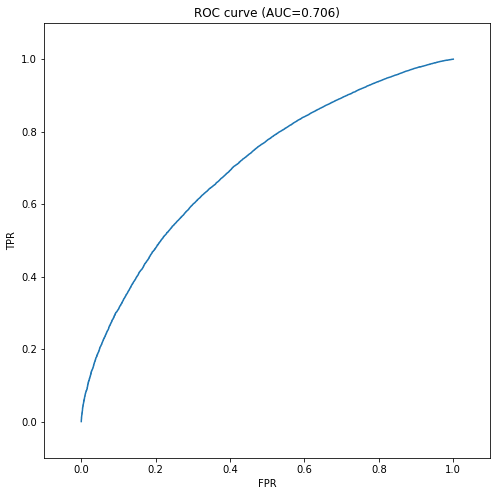

Tree: 


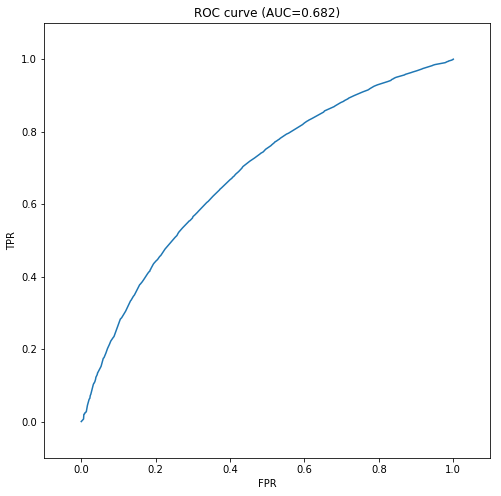

L1: 


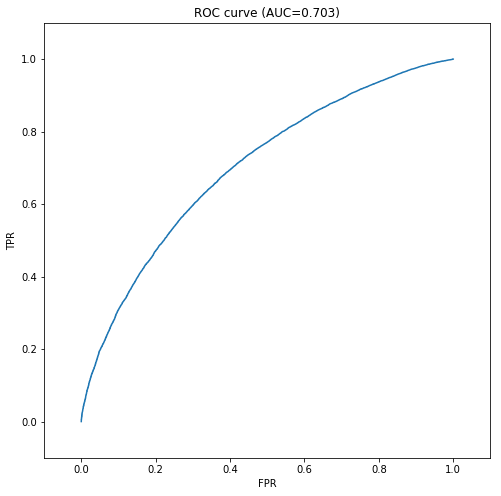

L2: 


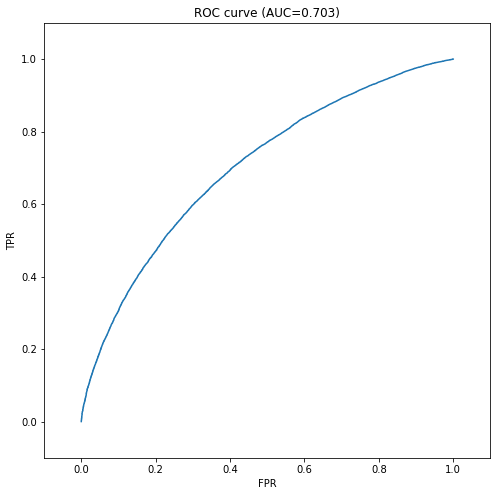

XGB: 


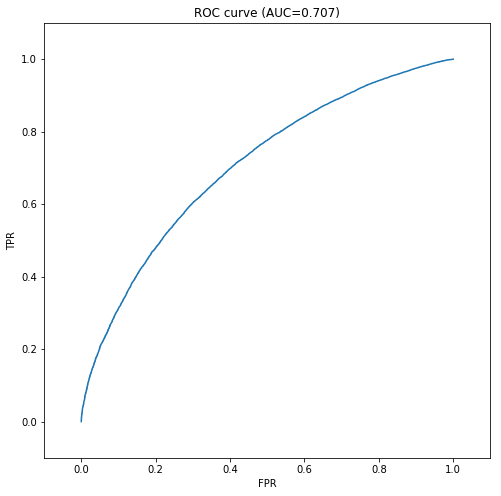

0.7071388165141193

In [18]:
def calculate_score_on_dataset_and_show_graph(X_test, y_test, model):
    import sklearn.metrics
    import matplotlib.pylab as pl
#     pl.style.use('ggplot')
    preds = model.predict_proba(X_test)
    preds = preds[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    auc = sklearn.metrics.auc(fpr, tpr)
    
    pl.figure(figsize=(8, 8,))
    pl.plot(fpr, tpr)
    pl.xlim([-0.1, 1.1])
    pl.ylim([-0.1, 1.1])
    pl.xlabel('FPR')
    pl.ylabel('TPR')
    pl.title('ROC curve (AUC={:.3f})'.format(auc))
    pl.show()
    
    return auc
print('Forest: ')
calculate_score_on_dataset_and_show_graph(X_test, y_test, forest_tree)
print('Tree: ')
calculate_score_on_dataset_and_show_graph(X_test, y_test, reg_tree)
print('L1: ')
calculate_score_on_dataset_and_show_graph(X_test, y_test, model_l1)
print('L2: ')
calculate_score_on_dataset_and_show_graph(X_test, y_test, model_l2)
print('XGB: ')
calculate_score_on_dataset_and_show_graph(X_test, y_test, xg_reg)

In [18]:
import operator 


def getNeighbors(X_train, y_train, X_test, k):
    distances = []
    length = len(X_test) 
    neighbors = []
    i = 0
    for x in X_train:
        distance = np.linalg.norm(X_test - x)
        distances.append((y_train[i], distance))
        i += 1
    distances.sort(key=operator.itemgetter(1))
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [19]:
def getResponse(neighbors):
    classVotes = {}
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    sortedVotes = sorted(classVotes.items(), key = operator.itemgetter(1), reverse=True)
    return sortedVotes

In [ ]:
predictions = []
k = 3
X = numeric_data.drop(['loan_status', 'verification_status', 'zip_code', 'grade_le', 'sub_grade_le', 'emp_title_le', 'purpose_le'], axis=1)
y = numeric_data['loan_status']
X = scale(X)

ros = RandomUnderSampler(random_state=0)
X, y = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

print(len(X_test))

i = 0
for x in X_test:
    neighbors = getNeighbors(X_train, y_train, x, k)
    if neighbors is not None:
        result = getResponse(neighbors)
        predictions.append(result[0][0])
#         print('predicted: ' + str(result))
#         print('actual: ' + str(y_test[i]))
#         print(len(predictions))
        i += 1
print('Own Knn: ')

print('Recall score: ' + str(metrics.recall_score(y_test, predictions)))

print('Precision score: ' + str(metrics.precision_score(y_test, predictions)))

print('Auc score: ' + str(metrics.roc_auc_score(y_test, predictions)))